# FermiPy

Fermipy is a python package that facilitates analysis of data from the Large Area Telescope (LAT) with the Fermi Science Tools.

The Fermipy package is built on the [pyLikelihood interface](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_tutorial.html) of the Fermi Science Tools and provides a set of high-level tools for performing common analysis tasks:

* Data and model preparation with the gt-tools (gtselect, gtmktime, etc.).
* Extracting a spectral energy distribution (SED) of a source.
* Generating TS maps for a region of interest.
* Finding new source candidates.
* Localizing a source or fitting its spatial extension.
* Fermipy uses a configuration-file driven workflow in which the analysis parameters (data selection, IRFs, and ROI model) are defined in a YAML configuration file. Analysis is executed through a python script that calls the methods of GTAnalysis to perform different analysis operations.

For instructions on installing Fermipy see the [Installation](http://fermipy.readthedocs.io/en/latest/install.html#install) page. For a short introduction to using Fermipy see the [Quickstart Guide](http://fermipy.readthedocs.io/en/latest/quickstart.html#quickstart).

## Community Driven Project

All of the code is on [GitHub](https://github.com/fermiPy).  If you have questions about using Fermipy please open a [GitHub Issue](https://github.com/fermiPy/fermipy/issues) or email the [Fermipy developers](fermipy.developers%40gmail.com).

I encourage you to look at the code and improve it and give back to the project

## Example Analysis of Gamma-ray Blazar 3C 279

We are doing a [binned likelihood analysis](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/binned_likelihood_tutorial.html) with Fermipy using a month of LAT data in the region that contains 3C 279.  Check out the [LAT monitored source list daily light curve](https://fermi.gsfc.nasa.gov/FTP/glast/data/lat/catalogs/asp/current/lightcurves/3C279_86400.png) for this source.

To run this notebook with precomputed files, you should download 

you have already downloaded ```fermipyTutorialData.tgz``` and unzipped it in a directory called ```/data/FermipyTutorial``` in the FermiBottle container. See the detailed setup instructions posted in the Fermi School Schedule. 

The downloaded file provides the configuration file for fermipy, this notebook file, photon and spacecraft files for 3C 279, and precomputed files allowing you to skip come calculation steps in the example analysis. When you run an analysis from scratch, some steps, especially computing the exposure and source model maps, will take longer. A more detailed analysis that includes more sources and a longer interval can take much longer. 

*FYI: Some Fermi analysis tools can take advantage of threading. Pieces of the analysis work flow can be run separately. There are various strategies you can use to allow efficient analysis across multiple computer processors to handle a large number of sources or a more complex analysis or set of analyses.*


### Import packages and utilities

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
ls

 config.yaml             data/             'Likelihood With fermiPy.ipynb'
'Curvature Test.ipynb'   Lightcurve.ipynb  'SED Stuff.ipynb'


## Config File

The first step is to compose a configuration file that defines the data selection and analysis parameters. Complete documentation on the configuration file and available options is given in the [Configuration](http://fermipy.readthedocs.io/en/latest/config.html#config) page. fermiPy uses the [YAML](http://yaml.org/) format for its configuration files. This is a text file and you can edit it with whichever text editor you prefer.

Our file is called ```config.yaml``` and it looks like this:

```
data:
  evfile : events.txt
  scfile : SC00.fits

binning:
  roiwidth   : 15.0
  binsz      : 0.1
  binsperdec : 8

selection :
  emin : 100
  emax : 100000
  zmax    : 90
  evclass : 128
  evtype  : 3
  tmin    : 239557417
  tmax    : 255398400
  filter  : 'DATA_QUAL>0 && LAT_CONFIG==1'
  target : '3C 279'

gtlike:
  edisp : True
  edisp_bins: -1
  irfs : 'P8R3_SOURCE_V3'
  edisp_disable: ['isodiff']

model:
  src_roiwidth : 20.0
  galdiff  : '$(CONDA_PREFIX)/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits'
  isodiff  : 'iso_P8R3_SOURCE_V3_v1.txt'
  catalogs : ['4FGL-DR3']

components:
  - { selection : { evtype : 4  } } # PSF0
  - { selection : { evtype : 8  } } # PSF1
  - { selection : { evtype : 16 } } # PSF2
  - { selection : { evtype : 32 } } # PSF3

fileio:
   outdir : data
```

#### Notes on the configuration file

For the data, events.txt is a file that lists the photon files downloaded for the region around 3C 279 from the LAT data server. For most analysis, you will download more than one photon file from the data server and will need a list. SC00.fits is the spacecraft file. See the tutorial from week 1 for more information about these files and how to download them.

We choose an roi width of 15 deg.  That is a square region with a full width of 15 deg. It is comfortably bigger than the LAT point spread function at 100 MeV to makes ure that we include the photons from 3C 279 and is big enough to include some neighboring sources around 3C 279. It is small enough to exclude many more distant sources that could complicate your analysis without improving the fit for 3C 279. 3C 279 is not close to the Galactic plan and so the source density around it is relatively low. For sources near the Galactic plane and especially near the Galactic center, you might choose a smaller roiwidth to limit the number of sources you need to model. The region does need to be big enough to model your target source and its nearest neighbors. This square ROI needs to fit fully inside the circular region that you download from the data server. 

We are running a **binned likelihood analysis**. You can find [more information about that here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/binned_likelihood_tutorial.html). That means that when we compare the predicted counts from our model to the counts in our data, we are grouping the photons in bins of instrument coordinates and energy. The bin sizes used here, binsz : 0.1 means 0.1 deg x 0.1 deg in instrument coordinates and binsperdec : 8 means 8 bins in log energy per decade, are good choices for most analysis. Ideally, we would make each photon its own bin and apply the exact instrument response for the position and energy, but that become computationally cumbersome for a large number of photons. The response functions do not vary that rapidly with position and energy and so it makes sense to group similar photons together and apply the average response for a bin. 

The data selection can't exceed what you downloaded from the data server. In this case, we set the energy range from emin of 100 MeV to emax of 100 GeV. The range could go lower or higher, especially for a longer data set, but this is a good basic range that covers the peak in LAT sensitivity.

The zmax selection removes photons that are coming from the direction of the Earth, the brightest source in the gamma-ray sky. A zmax cut of 90 deg is recommended for most analysis to reduce this emission.

Selecting evclass 128 means we are selecting the Pass 8 Source Class. This event selection is good for most types of analysis, but there are [other options](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Data/LAT_DP.html) to reduce background and require the best reconstructed photons at the cost of less photons in the analysis.

The time selection set by tmin and tmax is in Fermi mission eleapsed time (MET seconds) and should match or can fall within the times for the data that you downloaded. Time is [described here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Data/Time_in_ScienceTools.html) in the Cicerone.

Selecting evtype 3 means that we are taking both photon conversion types, front and back, which have a different angular resolution and effective area. We will separate the data into 4 components for the analysis, selected at the bottom of this file, so that we can match the response more accurately using their PSF type. Event classes and types are [described here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Data/LAT_DP.html).

The filter statement goes to gtmktime and can make selections based on information in the spacecraft file. You probably won't have any reason to use something different from what is above, which will remove a tiny fraction of data taken when the LAT was not in a normal science configuration. If you are curious, everything that is in the spacecraft files is [described here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Data/LAT_Data_Columns.html#SpacecraftFile).

The target source sets the center of your region of interest (ROI) for the analysis.

When we run the likelihood fit, we need to select the instrument response functions that represent the data. If the data you have is Pass 8 data and you selected the source class, you need to use the P8R3_SOURCE_V3 response functions. There is a full list of response functions available to match current [data selections are here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/IRF_overview.html).

When we run the likelihood fit we can make a correction for the energy dispersion of the data. That will give us a better match of model predictions to the data in each energy bin. The correction has a noticeable impact in the lower part of the LAT band where there is more dispersion and for sources with steeper spectra, where shifts in the measured energy have a relatively larger effect. We recommend using the energy dispersion correction with edisp_bins : -1. You should edsip_disable to disable the energy dispersion correction for the isotropic diffuse emission because that template is derived from the data and already includes dispersion. By definition, that model is designed to match the data. You can learn more about [energy dispersion in the LAT here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Pass8_edisp_usage.html).

We also configure the source model. The src_roiwidth sets the size of the region for including sources in the model. This is larger than the ROI we are analyzing (roiwidth in the binning section) because the sources a little outside that region can contribute photons because of the extent of LAT's point spread function. We also need to tell the model method where to find files describing the interstellar emission (Galactic diffuse) and the isotropic diffuse emission. Fianlly, we can give fermipy a catalog file so that it can automatically generate a model for our region using the catalog locations and spectral information.

Selecting components means that we will run a likelihood analysis on different sections of the data and combine the results. This is neat trick you can do with likelihood because the log likelihood for fits of independent data sets can be added to give an overall likelihood. The advantage of this is that you can break the data into pieces with more accurate response representations that give better sensitivity to sources.

There are additional things that you can do in the configuration file, but this gives you a good standard analysis that you can use for many sources.

## Import the package

In [3]:
from fermipy.gtanalysis import GTAnalysis

## Setup the object and load in the config file
We are reading in the configuration file here and configuring the analysis


In [4]:
gta = GTAnalysis('config.yaml',logging={'verbosity' : 3})

2024-04-26 17:46:20 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 1.2.0 
ScienceTools version 2.2.11


### The log file

Everything that FermiPy does is saved in a log file so that you can go back and see what you've done. The log file is a text file and you can view it with whichever text viewer you prefer (ls, cat, vim, emacs, TextEdit...). The tail commend used here is a quick way to look at the last n lines of a file.

In [5]:
!tail -n50 data/fermipy.log

  isodiff:
  - iso_P8R3_SOURCE_V3_v1.txt
  limbdiff: []
  merge_sources: true
  sources: []
  src_radius: null
  src_radius_roi: null
  src_roiwidth: 20.0
name: '03'
selection:
  convtype: null
  dec: null
  emax: 100000.0
  emin: 100.0
  evclass: 128
  evtype: 32
  filter: DATA_QUAL>0 && LAT_CONFIG==1
  glat: null
  glon: null
  logemax: !!python/object/apply:numpy.core.multiarray.scalar
  - &id001 !!python/object/apply:numpy.dtype
    args:
    - f8
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
    - null
    - null
    - -1
    - -1
    - 0
  - !!binary |
    AAAAAAAAFEA=
  logemin: !!python/object/apply:numpy.core.multiarray.scalar
  - *id001
  - !!binary |
    AAAAAAAAAEA=
  phasemax: null
  phasemin: null
  ra: null
  radius: 11.106601717798213
  roicut: 'no'
  target: 3C 279
  tmax: 255398400
  tmin: 239557417
  zmax: 90.0



## Run the setup step

This step will load any precomputed files (livetime, exposure, source maps).  If the files don't already exist, will create them.  It also sets up the likelihood method so that we can do a fit to a model of the 3C 279 region.  

The ```setup()``` method performs the data preparation and response calculations needed for the analysis. It selects the data, creates count maps binned in energy, computes the livetime for the selection, calculates exposure maps binned to match your data selection, and calculates model maps for the sources. These are the pieces that will be used to do the likelihood optimization of the model. Depending on the data selection and binning of the analysis the setup step will often be the slowest step in the analysis sequence. The output files generated during ```setup()``` are saved in the analysis working directory. Subsequent calls to ```setup()``` reuse those files and it will run much faster. 

*Note that if you want to change your configuration (for example, change the size or center of the region, the energy range, the spatial or energy binning, or which response functions are used) you need to remove files that were calculated for a different configuration. If you make a change to the config.yaml file, it is a good idea to create a new clean directory to ensure that the livetime, exposure and source map files match your data selection and configuration settings. This is a common reason for problems when rerunning an analysis after fixing something in the config.yaml file* 

In [6]:
gta.setup()

2024-04-26 17:46:27 INFO    GTAnalysis.setup(): Running setup.
2024-04-26 17:46:27 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2024-04-26 17:46:27 INFO    GTBinnedAnalysis.run_gtapp(): Running gtselect.
2024-04-26 17:46:27 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtselect infile=/data/fermi-summer-school/Likelihood_Advanced/data/evfile_00.txt outfile=/data/fermi-summer-school/Likelihood_Advanced/data/ft1_00.fits ra=194.04150390625 dec=-5.788700103759766 rad=11.106601717798213 tmin=239557417.0 tmax=255398400.0 emin=100.0 emax=100000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=4 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=3 clobber=yes debug=no gui=no mode="ql"
2024-04-26 17:46:27 INFO    GTBinnedAnalysis.run_gtapp(): This is gtselect version HEAD
2024-04-26 17:46:27 INFO    GTBinnedAnalysis.run_gtapp(): Applying filter string: ((EVENT_CLASS&o200) != o0) && angsep(RA,DEC,194.0415039,-5.788700104) < 11.10660172 && ((EVENT_TYPE&o4) != o0) && 100 < E

2024-04-26 17:46:31 INFO    GTBinnedAnalysis.run_gtapp(): Applying filter string: ((EVENT_CLASS&o200) != o0) && angsep(RA,DEC,194.0415039,-5.788700104) < 11.10660172 && ((EVENT_TYPE&o40) != o0) && 100 < ENERGY && ENERGY <= 100000 && 239557417 < TIME && TIME <= 255398400 && 0 < ZENITH_ANGLE && ZENITH_ANGLE <= 90 && gtifilter()
2024-04-26 17:46:31 INFO    GTBinnedAnalysis.run_gtapp(): Done.
2024-04-26 17:46:31 INFO    GTBinnedAnalysis.run_gtapp(): Finished gtselect. Execution time: 0.47 s
2024-04-26 17:46:31 INFO    GTBinnedAnalysis.run_gtapp(): Running gtmktime.
2024-04-26 17:46:31 INFO    GTBinnedAnalysis.run_gtapp(): time -p gtmktime scfile=/data/fermi-summer-school/Likelihood_Advanced/data/SC00.fits sctable="SC_DATA" filter="DATA_QUAL>0 && LAT_CONFIG==1" roicut=no evfile=/data/fermi-summer-school/Likelihood_Advanced/data/ft1_03.fits evtable="EVENTS" outfile="/data/fermi-summer-school/Likelihood_Advanced/data/ft1_filtered_03.fits" apply_filter=yes overwrite=no header_obstimes=yes tsta

Drm_Cache::update Measured counts < 0 4FGL J1221.4-0634 23 -3.16963e-12 5.8433e-12
0.57141 0.63714 0.627586 0.554603 0.444619 0.330903 0.219693 0.132171 0.0712835 0.032272 0.0133772 0.00410797 0.00140145 0.00031844 9.72625e-05 2.14837e-05 6.37548e-06 1.5398e-06 4.17718e-07 8.85368e-08 1.37222e-08 1.48829e-09 1.23325e-10 5.8433e-12 


2024-04-26 17:46:48 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 02.
2024-04-26 17:46:56 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 03.
2024-04-26 17:47:06 INFO    GTAnalysis.setup(): Initializing source properties
2024-04-26 17:47:08 INFO    GTAnalysis.setup(): Finished setup.


## Optimize the Model of the Region of Interest

The optimize step runs a loop over the model components in the region of interest (ROI) and fits the spectral normalization and shape parameters for each source. This creates an initial estimate for the model for the region. Later, we will refine it. We picked up default shapes and parameter values in the setup step from the 4FGL catalog. That is why we listed that catalog in ```config.yaml```. This method computes a Test Statistic (TS) and a predicted photon count for each of the 4FGL sources using the optimized fit parameters. This can be useful for identifying weak sources that should have their parameters fixed or that could be removed from the model if they are way too faint to detect in this data set. Recall that the 4FGL catalog contains sources detected using 8 years of data. Here we are using only a few months.

In [7]:
opt1 = gta.optimize()

2024-04-26 17:47:35 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['galdiff', '4FGL J1256.1-0547', 'isodiff', '4FGL J1229.0+0202', '4FGL J1312.8-0425']
Fitting shape 4FGL J1256.1-0547 TS:  13060.224
Fitting shape galdiff TS:   3918.076
Fitting shape 4FGL J1229.0+0202 TS:   1724.168
Fitting shape isodiff TS:    616.294
Fitting shape 4FGL J1312.7+0050 TS:    149.778
Fitting shape 4FGL J1322.6-0936 TS:    119.526
Fitting shape 4FGL J1256.2-1146 TS:     37.154
Fitting shape 4FGL J1332.6-1256 TS:     27.727
Fitting shape 4FGL J1233.7-0144 TS:     26.091


2024-04-26 17:47:58 INFO    GTAnalysis.optimize(): Finished
2024-04-26 17:47:58 INFO    GTAnalysis.optimize(): LogLike: -138365.031016 Delta-LogLike: 282.638372
2024-04-26 17:47:58 INFO    GTAnalysis.optimize(): Execution time: 22.32 s


We saved the output of this step in a variable called _opt 1_.  It's just a python dictionary.

In [8]:
opt1

{'loglike0': -138647.6693872976,
 'loglike1': -138365.03101577517,
 'dloglike': 282.63837152242195,
 'config': {'npred_threshold': 1.0,
  'npred_frac': 0.95,
  'shape_ts_threshold': 25.0,
  'max_free_sources': 5,
  'skip': [],
  'optimizer': {'optimizer': 'MINUIT',
   'tol': 0.001,
   'max_iter': 100,
   'init_lambda': 0.0001,
   'retries': 3,
   'min_fit_quality': 2,
   'verbosity': 0}}}

We can also look at a summary of the results using the ```print_roi()``` function:

In [9]:
gta.print_roi()

2024-04-26 17:48:06 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1256.1-0547   PointSource    PLSuperExpCuto    0.000  15267.16      7517.0
4FGL J1258.7-0452   PointSource    PowerLaw          1.122      2.38         7.2
4FGL J1249.3-0545   PointSource    PowerLaw          1.707      1.83        36.1
4FGL J1304.6-0348   PointSource    LogParabola       2.899      2.14        11.1
4FGL J1310.1-0450   PointSource    PowerLaw          3.612      1.25        19.2
4FGL J1251.3-0201   PointSource    LogParabola       3.949      0.04         1.6
4FGL J1312.8-0425   PointSource    LogParabola       4.378      0.93        13.5
4FGL J1243.9-0218   PointSource    LogParabola       4.627     12.03        38.9
4FGL J1315.9-0732   PointSource    LogParabola       5.216     17.16        37.1
4FGL J1234.7-0434   PointSource    PowerLaw          5.4

### Delete sources that are not detected

The ROI summary table above gives the source catalog name, the spatial mode type, the spectral model type, the offset from the center of the region of interest (ROI) that we selected, the test statistic (TS) for the optimized fit we just ran, and the number of predicted counts (npred) for the optimized fit. 

The test statistic is defined as $TS = -2 \ln(L_0/L_s)$, where $L_0$ is the maximum likelihood of the baseline model of the region without the source and $L_s$ is the maximum likelihood of the model with the source included. If the added source does not improve the match of the model to the data, then $TS$ will be 0 or very small. For the models we are considering here, $TS$ is distributed like $\chi^2$, and you can use Gaussian approximation to evaluate it. The $\sqrt(TS)$ as an approximation of Gaussian width. We will talk in more detail about the method of maximum likelihood and statistical tests of the data. This is just to give you a basic idea about how to evaluate the likelihood fit in this tutorial.

In this case, $TS = 9$ is a $3~\sigma$ detection -- pretty weak. Note that there are sources that are not detected at all that have $TS \sim 0$ or predicted counts < 1. Let's remove sources that have a $TS < 3$. In this example, no additional sources will be removed, but we can also explicitly delete sources that have predicted counts < 3. The fit will make a best guess based on the catalog input, but you really need more than 1 photon to fit a spectrum. Removing nondetected sources will make the model and the fit to the data simpler. 

In [10]:
gta.delete_sources?

In [11]:
deleted_sources = gta.delete_sources(minmax_ts=[-1,3])

2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1258.7-0452
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1249.3-0545
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1304.6-0348
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1310.1-0450
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1251.3-0201
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1312.8-0425
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1314.7-0901
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1231.8-0450
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1317.5-0153
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1228.7-0318
2024-04-26 17:48:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1246.3+0112
2024-04-26

In [12]:
deleted_sources = gta.delete_sources(minmax_npred=[0,3])

2024-04-26 17:48:17 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1331.7-0647
2024-04-26 17:48:17 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1235.1-1405
2024-04-26 17:48:17 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1241.8-1456
2024-04-26 17:48:17 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1216.4-1358


In [13]:
gta.print_roi()

2024-04-26 17:48:18 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1256.1-0547   PointSource    PLSuperExpCuto    0.000  15267.16      7517.0
4FGL J1243.9-0218   PointSource    LogParabola       4.627     12.03        38.9
4FGL J1315.9-0732   PointSource    LogParabola       5.216     17.16        37.1
4FGL J1234.7-0434   PointSource    PowerLaw          5.469      4.19        26.1
4FGL J1256.2-1146   PointSource    PowerLaw          5.987     37.53        90.2
4FGL J1322.3-0606   PointSource    LogParabola       6.518     11.12        18.1
4FGL J1233.7-0144   PointSource    PowerLaw          6.904     28.26       105.8
4FGL J1310.2-1158   PointSource    PowerLaw          7.100     15.52        50.6
4FGL J1311.0+0034   PointSource    PowerLaw          7.357     21.27        66.5
4FGL J1322.6-0936   PointSource    LogParabola       7.5

### Free source parameters in the model

When sources are close to our target source, we need to let the fit vary their model parameters. To find the best fit for the target source, we consider the overlap of the nearby sources because of the width and tails of the LAT point spread function. We have to find the best fit parameters for nearby sources as well as the target source to have a good model of the region. 

In the next step, we will free the spectral parameters for sources close to the target, within 3 deg of the center of our region of interest (this could be made larger or smaller depending on the analysis and region), and do a more detailed fit for that inner circle of the region. The parameters will be fixed to the optimized value from above for sources that are farther away and have less influence on the target location. In this example we will leave all the spectral shapes fixed and only vary the normalization parameters. In same cases, we might want to allow some shapes to vary, too.

It is also important to leave parameters free for any relatively high TS sources in the region and to leave parameters free for the isotropic and interstellar emission (Galactic diffuse) models. The underlying need is that we must give the fit enough degrees of freedom to find the best representation of the data given our model. Ideally, we would simultaneously fit the entire sky, but that presents many difficulties and for a single source analysis, this approach is sufficient. 

In [14]:
# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free sources with TS > 10
gta.free_sources(minmax_ts=[10,None],pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('galdiff')
gta.free_source('isodiff')

#Free shape parameters of 4FGL J1256.1-0547 (but keep Index2 fixed)
gta.free_source("4FGL J1256.1-0547")

2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1256.1-0547     : ['Prefactor']
2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for isodiff               : ['Normalization']
2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Prefactor']
2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1243.9-0218     : ['norm']
2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1315.9-0732     : ['norm']
2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1256.2-1146     : ['Prefactor']
2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1322.3-0606     : ['norm']
2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1233.7-0144     : ['Prefactor']
2024-04-26 17:48:22 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1310.2-1

## Fit the refined model of the ROI

Now we will do the fit using our refined model of the region. We will save the results in the ```fit1``` variable.

In [15]:
fit1 = gta.fit()

2024-04-26 17:48:25 INFO    GTAnalysis.fit(): Starting fit.
/opt/anaconda/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2024-04-26 17:48:30 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2024-04-26 17:48:30 INFO    GTAnalysis.fit(): LogLike:  -138380.011 DeltaLogLike:        7.391 


It looks like the fit returned successfully. That means that the minimization completed normally - a good thing. If the fit routine is struggling to find best-fit parameters for the model, it will complain.

In [16]:
gta.print_roi()

2024-04-26 17:48:30 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1256.1-0547   PointSource    PLSuperExpCuto    0.000  13258.48      7521.9
4FGL J1243.9-0218   PointSource    LogParabola       4.627     11.89        38.6
4FGL J1315.9-0732   PointSource    LogParabola       5.216     17.13        37.1
4FGL J1234.7-0434   PointSource    PowerLaw          5.469      4.19        26.1
4FGL J1256.2-1146   PointSource    PowerLaw          5.987     35.76        87.0
4FGL J1322.3-0606   PointSource    LogParabola       6.518     11.59        18.7
4FGL J1233.7-0144   PointSource    PowerLaw          6.904     28.03       107.1
4FGL J1310.2-1158   PointSource    PowerLaw          7.100     14.79        47.8
4FGL J1311.0+0034   PointSource    PowerLaw          7.357     24.23        77.5
4FGL J1322.6-0936   PointSource    LogParabola       7.5

In [17]:
print(gta.roi['4FGL J1256.1-0547'])

Name           : 4FGL J1256.1-0547
Associations   : ['4FGL J1256.1-0547', '3C 279', '2AGL J1255-0543', '3EG J1255-0549']
RA/DEC         :    194.042/    -5.789
GLON/GLAT      :    305.095/    57.063
TS             : 13258.48
Npred          : 7521.93
Flux           :  6.37e-07 +/- 1.48e-08
EnergyFlux     : 0.0002557 +/- 9.28e-06
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff4
Spectral Parameters
b'Prefactor'   :  5.991e-11 +/-  2.003e-12
b'IndexS'      :     -2.224 +/-    0.02672
b'Scale'       :      954.1 +/-        nan
b'ExpfactorS'  :     0.1278 +/-    0.02933
b'Index2'      :     0.2419 +/-        nan


You can save the results (and reload them later which is really nice).  Note that this method saves plots in a fits file and the results of the fits in a numpy file in the data subdirectory of the working directory for this analysis.

In [18]:
gta.write_roi('fit1',make_plots=True)

2024-04-26 17:48:35 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1_00.xml...
2024-04-26 17:48:35 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1_01.xml...
2024-04-26 17:48:35 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1_02.xml...
2024-04-26 17:48:35 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1_03.xml...
2024-04-26 17:48:35 INFO    GTAnalysis.write_fits(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1.fits...
2024-04-26 17:48:42 INFO    GTAnalysis.write_roi(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit1.npy...


In [19]:
ls data/*.png

data/fit1_counts_map_2.000_5.000.png        data/fit1_counts_spectrum.png
data/fit1_counts_map_xproj_2.000_5.000.png  data/fit1_model_map_2.000_5.000.png
data/fit1_counts_map_yproj_2.000_5.000.png


![fit1_counts_spectrum.png](data/fit1_counts_spectrum.png)
![fit1_counts_map_2.000_5.000.png](data/fit1_counts_map_2.000_5.000.png)
![fit1_model_map_2.000_5.000.png](data/fit1_model_map_2.000_5.000.png)
![fit1_counts_map_xproj_2.000_5.000.png](data/fit1_counts_map_xproj_2.000_5.000.png)  
![fit1_counts_map_yproj_2.000_5.000.png](data/fit1_counts_map_yproj_2.000_5.000.png)

Before we continue to examine the best fit results, let's fix the parameters for all of the sources.

In [20]:
fixed_sources = gta.free_sources(free=False)

2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1256.1-0547     : ['Prefactor', 'IndexS', 'ExpfactorS']
2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1243.9-0218     : ['norm']
2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1315.9-0732     : ['norm']
2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1256.2-1146     : ['Prefactor']
2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1322.3-0606     : ['norm']
2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1233.7-0144     : ['Prefactor']
2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1310.2-1158     : ['Prefactor']
2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1311.0+0034     : ['Prefactor']
2024-04-26 17:49:16 INFO    GTAnalysis.free_source(): Fixing parameters for 4FG

### Generate Residual Count Maps

A residual count map shows the unmodeled counts after we subtract the counts from the modeled sources from the counts in the data for the region. This can be positive or negative depending on whether the model underpredicts or overpredicts the counts in each spatial bin.

In [21]:
resid = gta.residmap('3C 279',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2024-04-26 17:49:21 INFO    GTAnalysis.residmap(): Generating residual maps
2024-04-26 17:49:21 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2024-04-26 17:49:24 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2024-04-26 17:49:25 INFO    GTAnalysis.residmap(): Finished residual maps
2024-04-26 17:49:29 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/fermi-summer-school/Likelihood_Advanced/data/3C 279_pointsource_powerlaw_2.00_residmap.npy
2024-04-26 17:49:29 INFO    GTAnalysis.residmap(): Execution time: 8.04 s


There is a handy helper function, ROIPlotter, that makes pretty skymaps.

In [22]:
from fermipy.plotting import ROIPlotter

<Figure size 800x600 with 0 Axes>

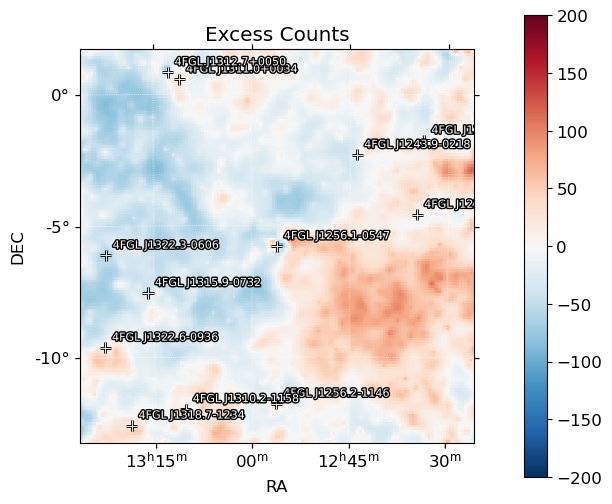

In [23]:
o = resid
plt.clf()
fig = plt.figure(figsize=(14,6))
ROIPlotter(o['excess'],roi=gta.roi).plot(vmin=-200,vmax=200,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

You can exclude a source when making a residual counts map to get a sense of the distribution of counts associated with that source in the fit. The test below will also give you an idea of what the residual counts map looks like when there is a point source missing from the model.

In [24]:
resid_noj1322 = gta.residmap('3C 279 noj1322',
                model={'SpatialModel' : 'PointSource', 'Index' : 2.0},
                exclude=['4FGL J1322.6-0936'])

2024-04-26 17:50:14 INFO    GTAnalysis.residmap(): Generating residual maps
2024-04-26 17:50:14 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2024-04-26 17:50:17 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2024-04-26 17:50:18 INFO    GTAnalysis.residmap(): Finished residual maps
2024-04-26 17:50:22 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/fermi-summer-school/Likelihood_Advanced/data/3C 279 noj1322_pointsource_powerlaw_2.00_residmap.npy
2024-04-26 17:50:22 INFO    GTAnalysis.residmap(): Execution time: 7.96 s


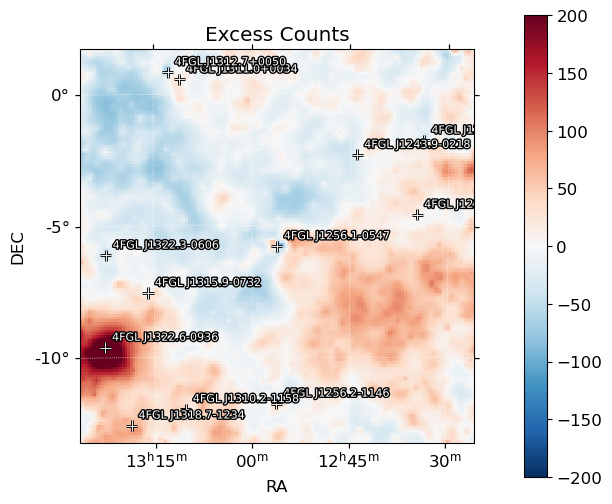

In [25]:
o = resid_noj1322
fig = plt.figure(figsize=(14,6))
ROIPlotter(o['excess'],roi=gta.roi).plot(vmin=-200,vmax=200,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

### Beware of simple significance calculations

It is difficult to make a reliable significance map from the residual counts map. You should not rely on the simple calculation used to generate a quick significance estimate in the fermipy residmap method. You should instead use the TS map method (see below) or similar robust methods to interpret the significance of excess unmodeled counts that you find in your analysis region. 

Let's take a look at the plot of the *distribution* of estimated significance values from the residual map shown above. There is a value for each bin in the map. Ideally, these values should be distributed according to a Gaussian distribution with mean 0 and width 1.

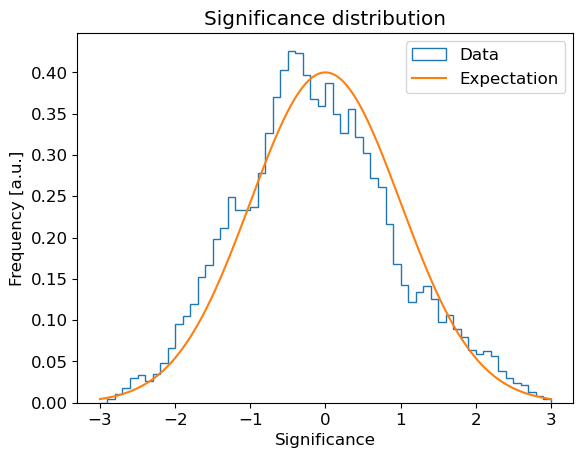

In [26]:
%matplotlib inline
n, _, _ = plt.hist( resid["sigma"].data.flatten(), bins=np.linspace(-3,3,61), \
                            density=True, histtype="step", label = "Data"  )
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
x = np.linspace(-3,3, 601)
y = np.exp(-x**2 / 2.0) #gaussian with mean 0 and width 1
norm = n.sum() * 0.1 / (y.sum() * 0.01) #norm factor
plt.plot(x, norm*y, label = "Expectation")
plt.xlabel("Significance")
plt.ylabel("Frequency [a.u.]")
plt.title("Significance distribution")
plt.legend()

As you can see, the significance histogram shows some deviation from the expectation. This is a known issue and is worse in some regions of the sky than in others. **We do not recommended using the residual maps for any quantitative statements about the goodness-of-fit, etc.** Instead, it is recommended to use TS maps (see below) or the [PSMap approach](https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/gtpsmap/gtpsmap.py). You can learn more from the [presentation on PSMap](https://indico.cern.ch/event/1010947/contributions/4278096/) given at the Fermi Symposium in April 2021.

## Make a TS map to evaluate unmodeled emission 

This is a map made by adding a tentative point source source at each location in the map and then calculating the likelihood ratio between the previously optimized model and the best-fit model with the additional source at that location. Recall that the test statistic is defined as $TS = -2 \ln(L_0/L_s)$, where $L_0$ is the likelihood of the original model and $L_s$ is the likelihood of the model with the additional source. Adding a source can only *improve* the model or leave the likelihood unchanged (if the best-fit flux is 0), hence the $TS$ can not be negative.

In [27]:
tsmap = gta.tsmap('3C 279',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2024-04-26 17:52:27 INFO    GTAnalysis.tsmap(): Generating TS map
2024-04-26 17:52:31 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2024-04-26 17:53:32 INFO    GTAnalysis.tsmap(): Finished TS map
2024-04-26 17:53:37 WARNING GTAnalysis.tsmap(): Saving TS maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/fermi-summer-school/Likelihood_Advanced/data/3C 279_pointsource_powerlaw_2.00_tsmap.npy
2024-04-26 17:53:37 INFO    GTAnalysis.tsmap(): Execution time: 69.78 s


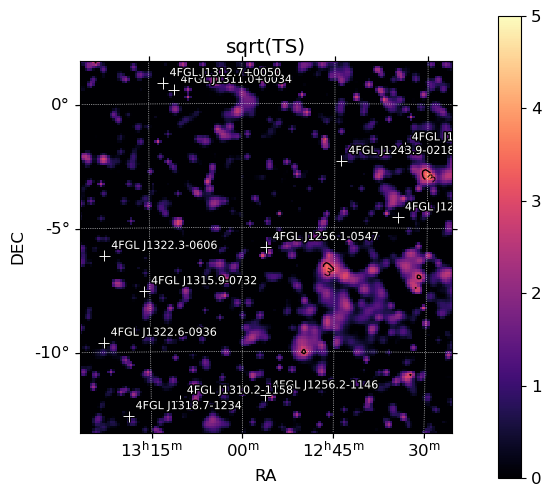

In [28]:
o = tsmap

fig = plt.figure(figsize=(6,6))
ROIPlotter(o['sqrt_ts'],roi=gta.roi).plot(vmin=0,vmax=5,levels=[3,5,7,9],subplot=111,cmap='magma')
plt.gca().set_title('sqrt(TS)')
plt.show()

We can play the same game again of excluding a source from the model and examining the TS map for that model.

In [29]:
tsmap_noj1322 = gta.tsmap('3C 279 noj1322',
                          model={'SpatialModel' : 'PointSource', 'Index' : 2.0},
                         exclude=['4FGL J1322.6-0936'])

2024-04-26 17:53:37 INFO    GTAnalysis.tsmap(): Generating TS map
2024-04-26 17:53:41 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2024-04-26 17:54:40 INFO    GTAnalysis.tsmap(): Finished TS map
2024-04-26 17:54:46 WARNING GTAnalysis.tsmap(): Saving TS maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/fermi-summer-school/Likelihood_Advanced/data/3C 279 noj1322_pointsource_powerlaw_2.00_tsmap.npy
2024-04-26 17:54:46 INFO    GTAnalysis.tsmap(): Execution time: 68.16 s


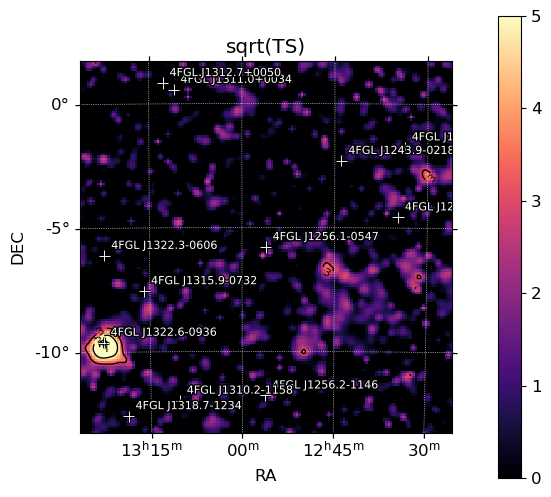

In [30]:
o = tsmap_noj1322

fig = plt.figure(figsize=(6,6))
ROIPlotter(o['sqrt_ts'],roi=gta.roi).plot(vmin=0,vmax=5,levels=[3,5,7,9],subplot=111,cmap='magma')
plt.gca().set_title('sqrt(TS)')
plt.show()

If you are curious about what the underlying diffuse emission looks like in this region (hint, it's not uniform over the sky), you can look at the residual counts for a model that does not include the interstellar emission.

In [31]:
resid_nogal = gta.residmap('3C 279 nogal',
                model={'SpatialModel' : 'PointSource', 'Index' : 2.0},
                exclude=['galdiff'])

2024-04-26 17:55:14 INFO    GTAnalysis.residmap(): Generating residual maps
2024-04-26 17:55:14 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2024-04-26 17:55:16 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2024-04-26 17:55:17 INFO    GTAnalysis.residmap(): Finished residual maps
2024-04-26 17:55:21 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/fermi-summer-school/Likelihood_Advanced/data/3C 279 nogal_pointsource_powerlaw_2.00_residmap.npy
2024-04-26 17:55:21 INFO    GTAnalysis.residmap(): Execution time: 7.78 s


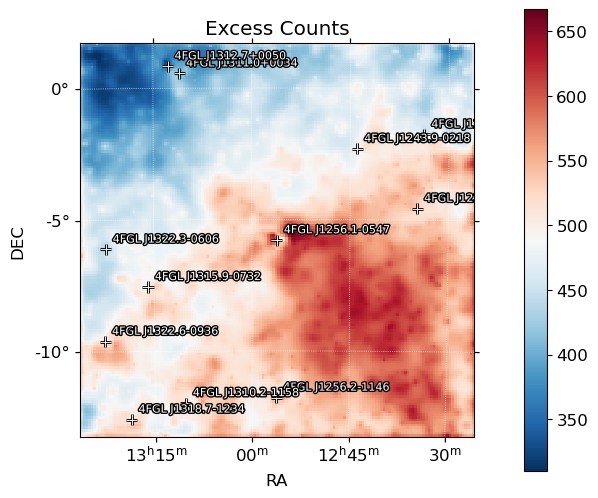

In [32]:
o = resid_nogal
fig = plt.figure(figsize=(14,6))
ROIPlotter(o['excess'],roi=gta.roi).plot(subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

## Make a spectral energy density plot for the target source

Fermipy includes advanced methods to help generate spectral energy density plots (SEDs) and light curves (see the [documentation](https://fermipy.readthedocs.io/en/latest/advanced/index.html)). Here is an example of making an SED for 3C 279. It is important to understand the underlying methods that are used for these so that you know how to apply them correctly in different analysis situations or how to adapt them to extract the information you need for your research. We will spend more time looking under the hood in the following tutorials.

In [33]:
sed = gta.sed('3C 279')

2024-04-26 17:55:58 INFO    GTAnalysis.sed(): Computing SED for 4FGL J1256.1-0547
2024-04-26 17:55:59 INFO    GTAnalysis._make_sed(): Fitting SED
2024-04-26 17:55:59 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1256.1-0547     : ['Prefactor']
/opt/anaconda/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2024-04-26 17:56:01 INFO    GTAnalysis.sed(): Finished SED
2024-04-26 17:56:05 INFO    GTAnalysis.sed(): Execution time: 6.57 s


In [34]:
source = gta.roi.get_source_by_name('4FGL J1256.1-0547')

In [35]:
E = np.array(source['model_flux']['energies'])
dnde = np.array(source['model_flux']['dnde'])
dnde_hi = np.array(source['model_flux']['dnde_hi'])
dnde_lo = np.array(source['model_flux']['dnde_lo'])

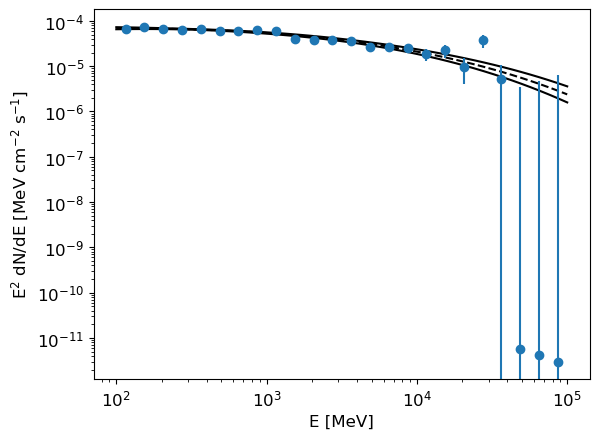

In [36]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

Hmmmm. Those error bars for the four highest energy bins seem consistent with a flux of zero. We're going to need to set some upper limits for those bins. Good news! the SED method has already calculated flux upper limit values at 95% confidence level. We just need to plot those for bins where the emission is not significant (here: below 20).

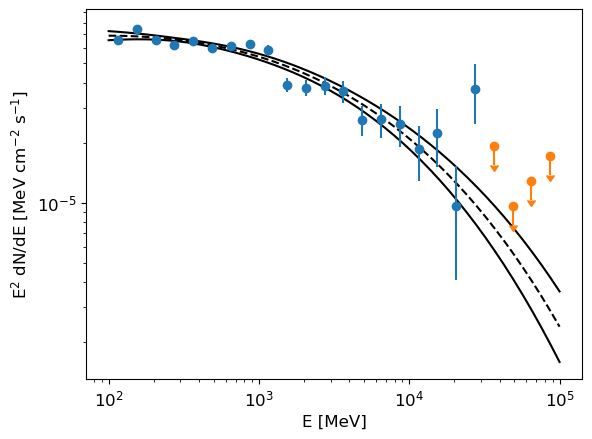

In [37]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')

TS_thresh=20
measurements=(sed['ts'] >= TS_thresh)
limits = (sed['ts'] < TS_thresh)

plt.errorbar(sed['e_ctr'][measurements],
             sed['e2dnde'][measurements], 
             yerr=sed['e2dnde_err'][measurements], fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][limits]), 
         sed['e2dnde_ul95'][limits], yerr=0.2*sed['e2dnde_ul95'][limits], 
             fmt='o', uplims=True)
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

We can save the fit results and plots from the SED method. 

In [38]:
gta.write_roi('fit2_sed',make_plots=True)

2024-04-26 17:56:35 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed_00.xml...
2024-04-26 17:56:35 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed_01.xml...
2024-04-26 17:56:36 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed_02.xml...
2024-04-26 17:56:36 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed_03.xml...
2024-04-26 17:56:36 INFO    GTAnalysis.write_fits(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed.fits...
2024-04-26 17:56:42 INFO    GTAnalysis.write_roi(): Writing /data/fermi-summer-school/Likelihood_Advanced/data/fit2_sed.npy...


## Introduction to extension fitting

We can also perform extension tests on a point source assuming two 'built-in' spatial templates in FermiPy: a radial disk (uniform surface brightness) or a radial Gaussian (Gaussian surface brightness). Significant extension is measured by $TS_{ext} = -2 \ln(L_0/L_{ext})$ where $L_0$ is the likelihood of the point source model and $L_{ext}$ is the likelihood of the extended source model. $TS_{ext} \gtrsim 16$ is a typical value considered for significant extension of a source. 

The extension fitting by default will scan through a range of extension sizes starting from 0.01 deg up to 1.0 degree for 21 logarithmically spaced width steps. 

There's lots you can do in an extension fitting including freeing the source position, backgrounds, and testing for extension in specific energy bins.

In [39]:
gta.extension?

For now, we will do a simple extension test. In more crowded regions, however, it may become important to free the source position and backgrounds (such as sources along the Galactic plane) to get an accurate picture of the source extension. 

In [40]:
gta.extension('4FGL J1256.1-0547',spatial_model='RadialDisk')

2024-04-26 18:13:32 INFO    GTAnalysis.extension(): Running extension fit for 4FGL J1256.1-0547
2024-04-26 18:13:54 INFO    GTAnalysis._extension(): Fitting extended-source model.
/opt/anaconda/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2024-04-26 18:14:06 INFO    GTAnalysis._extension(): Generating TS map.
2024-04-26 18:14:10 INFO    GTAnalysis._extension(): Testing point-source model.
2024-04-26 18:14:14 INFO    GTAnalysis._extension(): Best-fit extension: 0.0315 + 0.0271 -    nan
2024-04-26 18:14:14 INFO    GTAnalysis._extension(): TS_ext:        0.174
2024-04-26 18:14:14 INFO    GTAnalysis._extension(): Extension UL: 0.0705
2024-0

{'spatial_model': 'RadialDisk', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': True, 'write_npy': True, 'reoptimize': False, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None, 'loge_bins': []}
{'spatial_model': 'RadialDisk', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': 

2024-04-26 18:14:16 WARNING GTAnalysis.extension(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/fermi-summer-school/Likelihood_Advanced/data/4fgl_j1256.1-0547_ext.npy
2024-04-26 18:14:16 INFO    GTAnalysis.extension(): Execution time: 44.35 s


{'name': '4FGL J1256.1-0547', 'file': None, 'config': {'spatial_model': 'RadialDisk', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': True, 'write_npy': True, 'reoptimize': False, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None, 'loge_bins': []}, 'width': array([0.        , 0.01      , 0.01258925, 0.01584893, 0.01995262,
       0.02511886, 0.03162278, 0.03981072, 0.05011872, 0.06309573,
       0.07943282, 0.1       , 0.12589254, 0.15848932, 0.19952623,
       0.25118864, 0.31622777, 0.39810717, 0.50118723, 0.63095734,
       0.79432823, 1.        ]), 'dloglike': arra

MutableNamedTuple([('name', '4FGL J1256.1-0547'),
                   ('file', None),
                   ('config',
                    {'spatial_model': 'RadialDisk',
                     'width': [],
                     'fit_position': False,
                     'width_min': 0.01,
                     'width_max': 1.0,
                     'width_nstep': 21,
                     'free_background': False,
                     'fix_shape': False,
                     'free_radius': None,
                     'fit_ebin': False,
                     'update': False,
                     'save_model_map': False,
                     'sqrt_ts_threshold': None,
                     'psf_scale_fn': None,
                     'make_tsmap': True,
                     'tsmap_fitter': 'tsmap',
                     'make_plots': False,
                     'write_fits': True,
                     'write_npy': True,
                     'reoptimize': False,
                     'optimizer': {'opt

In [41]:
gta.extension('4FGL J1256.1-0547',spatial_model='RadialGaussian')

2024-04-26 18:14:49 INFO    GTAnalysis.extension(): Running extension fit for 4FGL J1256.1-0547
2024-04-26 18:15:13 INFO    GTAnalysis._extension(): Fitting extended-source model.
/opt/anaconda/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2024-04-26 18:15:25 INFO    GTAnalysis._extension(): Generating TS map.
2024-04-26 18:15:29 INFO    GTAnalysis._extension(): Testing point-source model.
2024-04-26 18:15:33 INFO    GTAnalysis._extension(): Best-fit extension: 0.0275 + 0.0246 -    nan
2024-04-26 18:15:33 INFO    GTAnalysis._extension(): TS_ext:        0.170
2024-04-26 18:15:33 INFO    GTAnalysis._extension(): Extension UL: 0.0639
2024-0

{'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': True, 'write_npy': True, 'reoptimize': False, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None, 'loge_bins': []}
{'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write

2024-04-26 18:15:35 WARNING GTAnalysis.extension(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /data/fermi-summer-school/Likelihood_Advanced/data/4fgl_j1256.1-0547_ext.npy
2024-04-26 18:15:35 INFO    GTAnalysis.extension(): Execution time: 46.30 s


{'name': '4FGL J1256.1-0547', 'file': None, 'config': {'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': True, 'write_npy': True, 'reoptimize': False, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None, 'loge_bins': []}, 'width': array([0.        , 0.01      , 0.01258925, 0.01584893, 0.01995262,
       0.02511886, 0.03162278, 0.03981072, 0.05011872, 0.06309573,
       0.07943282, 0.1       , 0.12589254, 0.15848932, 0.19952623,
       0.25118864, 0.31622777, 0.39810717, 0.50118723, 0.63095734,
       0.79432823, 1.        ]), 'dloglike': 

MutableNamedTuple([('name', '4FGL J1256.1-0547'),
                   ('file', None),
                   ('config',
                    {'spatial_model': 'RadialGaussian',
                     'width': [],
                     'fit_position': False,
                     'width_min': 0.01,
                     'width_max': 1.0,
                     'width_nstep': 21,
                     'free_background': False,
                     'fix_shape': False,
                     'free_radius': None,
                     'fit_ebin': False,
                     'update': False,
                     'save_model_map': False,
                     'sqrt_ts_threshold': None,
                     'psf_scale_fn': None,
                     'make_tsmap': True,
                     'tsmap_fitter': 'tsmap',
                     'make_plots': False,
                     'write_fits': True,
                     'write_npy': True,
                     'reoptimize': False,
                     'optimizer': {

## Summary

Congratulations! Now you've been through a sped-up basic fermipy maximum likelihood analysis of a bright source. We stepped through the methods while largely ignoring what we need to compute the inputs, construct a good model, and check that we get a good fit to the model. We also sidestepped some of the caluclation time involved in creating the inputs needed for the likelihood analysis. 

In the following weeks will look more closely at some of these steps. We will consider how you decide on the configuration for your analysis, how to create good likelihood models that test the questions you want to answer, and we will talk about how things might change for other types of sources and regions. Once you gain some understanding of what is needed for a likelihood analysis and what options you have to use maximum likelihood in the fermitools, we will consider how to extend our analysis to other types of sources and situations.

## Homework

This week we have homework. What source or type of source do you want to analyze in the Fermi data? 
Put some thought into selecting a source or an example source for your own analysis project. If you are not sure what to choose, you can post a message on slack in the #2021 channel, talk to team members on Gather after the live sessions, or stop by the Thursday office hours to get advice. We'll ask you to submit a project source next week.

We recommend picking something bright so that you can test out your analysis workflow on a small data set. 
We also recommend analyzing a source with some published or public results so that you know what to expect. 
Once you have things working, then it will be easier to tackle fainter or more complicated objects.